In [ ]:
#cd to the script folder
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('drive/My Drive/RL2025')#Need to change the address to where your script is
os.listdir('.')

Mounted at /content/drive


['val_history_BO.csv',
 'BO_toy1.ipynb',
 'CBO_toy1.ipynb',
 'val_history_CBO.csv',
 'sknw',
 '000.png',
 'CBO_toy2.ipynb',
 'Siamese_keras_test.keras',
 'temp',
 'y_accu_BO.npy',
 'y_accu_CBO.npy',
 'CBO.ipynb',
 'SiameseCBO_cheating_template.ipynb',
 'SiameseCBO_template.ipynb',
 'temp2',
 'test.ipynb',
 'SiameseCBO_archaived_03142025.ipynb',
 'SiameseCBO.ipynb',
 'SiameseCBO_1D_debug.ipynb',
 'temp3',
 'Copy of SiameseCBO_1D_BO.ipynb']

In [ ]:
##get a MNIST dataset from tensorflow
import tensorflow_datasets as tfds
import numpy as np

mnist = tfds.load('mnist')
images = np.array([example['image'] for example in mnist['train']])
labels = np.array([example['label'] for example in mnist['train']])
BW = images.reshape([images.shape[0],28,28])>128

In [ ]:
#!git clone https://github.com/Image-Py/sknw.git
!pip install ./sknw

Processing ./sknw
  Preparing metadata (setup.py) ... done
  Created wheel for sknw: filename=sknw-0.13-py3-none-any.whl size=4531 sha256=3a30a4dbb1ad88c158b57d3ccbcd9cfb26df179ade4e9380b62c84731b8bcd75
  Stored in directory: /tmp/pip-ephem-wheel-cache-g5scjyxt/wheels/ec/38/47/cd31f2089ad83ee4356d813041880d4a2f9096997188ac87df
Successfully built sknw


In [ ]:
import sknw
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist
from skimage.morphology import skeletonize
from skimage.metrics import structural_similarity as ssim
from skimage.filters import gaussian
from IPython import display
import time

def IMG2CUR(IMG, plot):
    ske = skeletonize(IMG).astype(np.uint16)
    graph = sknw.build_sknw(ske, multi=True)

    if plot:
        plt.imshow(IMG, cmap='gray')

    repCheck = set()
    branches = []
    for (s,e) in graph.edges():
        if not (s,e) in repCheck:
            for i in range(len(graph[s][e])):
                ps = graph[s][e][i]['pts']
                if plot:
                    plt.plot(ps[:,1], ps[:,0])
                branches.append(ps)
                repCheck.add((s,e))
        else:
            continue
    if plot:
        plt.title('Build Graph')
        plt.show()
    return tuple(branches)

def apply_psf(I0, x, y, PSF):
    """
    Paints pixels in I0 at (x, y) using a PSF kernel.

    Parameters:
        I0 (numpy.ndarray): Input image (grayscale or intensity map).
        x (int): X-coordinate (row index) where PSF is centered.
        y (int): Y-coordinate (column index) where PSF is centered.
        PSF (numpy.ndarray): n-by-n Point Spread Function (must be odd-sized).

    Returns:
        numpy.ndarray: Modified image after applying PSF.
    """
    I = I0.copy()  # Create a copy to avoid modifying the input
    n = PSF.shape[0]  # PSF kernel size (assumed square)
    half_n = n // 2   # Half size for indexing

    # Get valid region within image bounds
    x_start, x_end = max(0, x - half_n), min(I.shape[0], x + half_n + 1)
    y_start, y_end = max(0, y - half_n), min(I.shape[1], y + half_n + 1)
    if x_start >= I.shape[0] or y_start >= I.shape[1] or x_end < 0 or y_end < 0:
        return I
    # Get corresponding PSF region (cropped if near edges)
    psf_x_start = half_n - (x - x_start)
    psf_x_end = half_n + (x_end - x)
    psf_y_start = half_n - (y - y_start)
    psf_y_end = half_n + (y_end - y)

    # Apply PSF
    I[x_start:x_end, y_start:y_end] += PSF[psf_x_start:psf_x_end, psf_y_start:psf_y_end]

    return I

def gaussian_psf(sigma):
    """
    Generate a Gaussian Point Spread Function (PSF) with center pixel normalized to 1.

    Parameters:
        sigma (float): Standard deviation of the Gaussian kernel.

    Returns:
        numpy.ndarray: Gaussian PSF with center pixel set to 1.
    """
    # Compute the kernel size (ensuring it's odd)
    size = int(np.ceil(2 * 3 * sigma))  # At least 2x3xSigma
    if size % 2 == 0:
        size += 1  # Ensure the size is odd

    # Create an empty kernel
    psf = np.zeros((size, size))

    # Place a delta function at the center
    center = size // 2
    psf[center, center] = 1

    # Apply Gaussian filtering
    psf = gaussian(psf, sigma=sigma, mode='constant', cval=0)

    # Normalize so the center pixel is 1
    psf /= psf[center, center]

    return psf

def x_grid_search():
  x1 = np.linspace(-0.3,0.3,20)
  x2 = np.linspace(-0.3,0.3,20)
  xx,yy = np.meshgrid(x1,x2,)
  return np.array([xx.flatten(),yy.flatten()]).T

def mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

def printer_gene(BW_stack, v = 0.01):
    drift_v_real = (np.random.rand(1,2)-0.5)*0.3 ##initial drift value between -0.15 - 0.15
    while True:
        global compensation
        NO = np.random.choice(BW_stack.shape[0])
        I0 = BW_stack[NO,:,:]
        curves = IMG2CUR(I0, 0)
        drift_v_real =  drift_v_real + np.random.normal(0,v,[1,2]) ##give some random change to the current drift
        drift_v_real = np.clip(drift_v_real, -0.3, 0.3)
        drift_v_real[0,0] = 0
        drift_v = drift_v_real + compensation ##implement the proposed change
        drift_v = np.clip(drift_v, -0.3, 0.3) ##make sure it is not too off
        drift_v[0,0] = 0
        drift = np.array([[0,0]])
        sigma = 0.8
        PSF = gaussian_psf(sigma)
        I = np.zeros(I0.shape).astype('float')
        for curve in curves:
            for i in range(curve.shape[0]):
                drift = drift+drift_v
                I = apply_psf(I, curve[i,0] + np.round(drift[0,0]).astype(int), curve[i,1] + np.round(drift[0,1]).astype(int) , PSF)
        I[I>1] = 1
        I[I<0] = 0

        MSE = mse(BW[NO,:,:].astype('float'), I.astype('float'))
        SSIM, _ = ssim(BW[NO,:,:].astype('float'), I.astype('float'), full=True, data_range = 1)
        output_y = MSE/((1+SSIM)/2)
        #output_y = 1/output_y
        output_x = np.array([drift_v_real[0,0], drift_v_real[0,1], drift_v[0,0], drift_v[0,1]])
        yield(output_x, output_y, (I0.astype('float'),I))

def printer_gene_test(BW_stack, drift1):
      NO = np.random.choice(BW_stack.shape[0])
      I0 = BW_stack[NO,:,:]
      curves = IMG2CUR(I0, 0)
      drift_v = (np.random.rand(1,2)-0.5)*0.3
      drift_v[0,0] = 0
      drift_v[0,1] = drift1
      drift = np.array([[0,0]])
      sigma = 0.8
      PSF = gaussian_psf(sigma)
      I = np.zeros(I0.shape).astype('float')
      for curve in curves:
            for i in range(curve.shape[0]):
                drift = drift+drift_v
                I = apply_psf(I, curve[i,0] + np.round(drift[0,0]).astype(int), curve[i,1] + np.round(drift[0,1]).astype(int) , PSF)
      I[I>1] = 1
      I[I<0] = 0

      MSE = mse(BW[NO,:,:].astype('float'), I.astype('float'))
      SSIM, _ = ssim(BW[NO,:,:].astype('float'), I.astype('float'), full=True, data_range = 1)
      output_y = MSE/((1+SSIM)/2)
      output_x = np.array([drift_v[0,0], drift_v[0,1], compensation[0,0], compensation[0,1]])
      return(output_x, output_y, (I0.astype('float'),I))


def test_data_prepare(I0, I):
    x2 = x_grid_search()
    x0 = np.repeat(I0, x2.shape[0], axis = 0)
    x1 = np.repeat(I, x2.shape[0], axis = 0)
    return (x0,x1,x2)

def train_figure_drawer(predicted_mean, acqf, actions, rewards, traj, GT_display, xq1, xq2):
  x1_trans = np.linspace(-0.3,0.3,20)
  x2_trans = np.linspace(-0.3,0.3,20)
  predicted_mean = predicted_mean.reshape(20,20)
  GT_display = GT_display.reshape(20,20)
  acqf = acqf.reshape(20,20)
  vmax = GT_display.max()*0.8
  f,ax = plt.subplots(1,5,figsize=(20,4), constrained_layout = True)
  #h1 = ax[0].imshow(predicted_mean, extent = (0.3,-0.3,0.3,-0.3), vmin = 0, vmax = vmax)
  h1 = ax[0].imshow(predicted_mean, extent = (0.3,-0.3,0.3,-0.3))
  h2 = ax[1].imshow(acqf, extent = (-0.3,0.3,0.3,-0.3))
  ax[1].scatter(x2_trans[xq2],x1_trans[xq1],color = 'r', marker = 'x')
  h3 = ax[2].imshow( GT_display, extent = (-0.3,0.3,0.3,-0.3), vmin = 0, vmax = vmax)
  h4 = ax[3].plot(traj[:,0], traj[:,1], color = 'C1', linewidth = 0.33, label = 'Current condition', zorder=3)
  h4 = ax[3].plot(traj[:,0] + actions[:,0], traj[:,1] + actions[:,1], color = 'C2', linewidth = 0.75, label = 'Corrected condition', zorder=2)
  h5 = ax[4].plot(np.cumsum(rewards))
  ax[3].scatter(traj[-1:,0], traj[-1:,1], color = 'red', marker = 'x', s = 80, zorder=4)
  ax[3].scatter(traj[-1:,0] + actions[-1:,0], traj[-1:,1] + actions[-1:,1], color = 'C0', marker = 'x', s = 80, zorder=5)
  ax[3].set_xlim([-0.6,0.6])
  ax[3].set_ylim([-0.6,0.6])
  ax[3].set_aspect(1)
  ax[0].set_title("Predicted regret")
  ax[1].set_title("Acqf")
  ax[2].set_title("Designed reward")
  ax[3].set_title("Context trajectory")
  ax[4].set_title("Cumulative regret")

  for i in range(3):
    ax[i].set_xlabel('a1')
    ax[i].set_ylabel('a2')
  ax[3].set_xlabel('x1')
  ax[3].set_ylabel('x2')
  ax[3].invert_yaxis()
  ax[4].set_xlabel('Epoch')
  ax[4].set_ylabel('Cumulative regret')
  ax[4].set_box_aspect(1)
  ax[3].legend()
  f.colorbar(h1, ax=ax[0])
  f.colorbar(h2, ax=ax[1])
  f.colorbar(h3, ax=ax[2])
  return f,ax

In [ ]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
import math
import numpy as np
import matplotlib.pyplot as plt

class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)  # Output: 14x14

        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        return x

# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.base_cnn = BaseCNN()
        self.fc1 = nn.Linear(288, 32)  # Adjust based on Flattened output size
        self.fc2 = nn.Linear(32, 1)  # Output: (dx, dy)
        self.criterion = nn.MSELoss()

    def set_optimizer(self, lr):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, input1, input2):
        feat1 = self.base_cnn(input1)
        feat2 = self.base_cnn(input2)
        merged = torch.cat((feat1, feat2), dim=1)
        x = torch.relu(self.fc1(merged))
        x = self.fc2(x)
        return x

    def train_Siamese(self, input1, input2, target, input1_valid, input2_valid, target_valid, epochs, verbose = 1):
        num_samples = input1.size()[0]
        lossHist = np.zeros([epochs,2])
        for epoch in range(epochs):
            self.train()
            total_loss = 0.0
            indices = torch.randperm(input1.size(0))
            input1_r = input1[indices]
            input2_r = input2[indices]
            target_r = target[indices]

            for itr in range(num_samples):
                self.optimizer.zero_grad()
                output = self(input1_r[itr:itr+1], input2_r[itr:itr+1])
                loss = self.criterion(output, target_r[itr:itr+1])
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            avg_train_loss = total_loss / (itr+1)

            self.eval()
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                predictions = self(input1_valid, input2_valid)
                loss = self.criterion(predictions, target_valid)
            if verbose==2:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss*100: {avg_train_loss*100:.4f}, Valid Loss*100: {loss.item()*100:.4f}")
            lossHist[epoch,0] = avg_train_loss
            lossHist[epoch,1] = loss.item()
        if verbose==1:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss*100: {avg_train_loss*100:.4f}, Valid Loss*100: {loss.item()*100:.4f}")
        return lossHist



class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, Siamese):
        super(GPRegressionModel, self).__init__(None, None, likelihood)
        if Siamese is None:
            self.Siamese = SiameseNetwork()
        else:
            self.Siamese = Siamese
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())
        self.relu = nn.ReLU()
        self.scale_to_bounds1 = gpytorch.utils.grid.ScaleToBounds(-1., 1.)
        self.scale_to_bounds2 = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        #self.fc1 = nn.Linear(2, 1)
        #self.fc2 = nn.Linear(8, 4)

    def forward(self, x1, x2, x3):
        x1 = x1.view(-1,1,28,28)
        x2 = x2.view(-1,1,28,28)
        x12 = self.Siamese(x1,x2)
        x12 = self.scale_to_bounds1(x12)
        x3 = self.scale_to_bounds2(x3)
        x = torch.cat((x12, x3), dim=1)
        #x = torch.add(x3,x12)
        #x = self.relu(self.fc1(x))
        #x = self.fc1(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

        print(predictive_mean)
        return
        #return mean.cpu().detach().numpy(), lower.cpu().detach().numpy(), upper.cpu().detach().numpy()

class SiameseCBOModel():
    def __init__(self, train_x, train_y, Siamese = None, lr_front = 0.01, lr_rear=1e-5):

        # Initialize likelihood and model
        self.likelihood = GaussianLikelihood()
        self.likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.GreaterThan(1e-1)) ##try to constrain the noise to prevent overfitting
        self.gpmodel = GPRegressionModel(train_x, train_y, self.likelihood, Siamese = Siamese)
        for name,p in self.gpmodel.named_parameters():
            print(name,p.size())
        self.optimizer_front = self.optimizer_front = torch.optim.Adam([
            {'params': [param for name, param in self.gpmodel.named_parameters() if 'Siamese' not in name and 'likelihood' not in name]},
        ], lr=lr_front)
        print('====================')
        for name,p in self.gpmodel.named_parameters():
            if 'Siamese' not in name and 'likelihood' not in name:
              print(name,p.size())
        self.optimizer_rear = torch.optim.Adam(self.gpmodel.Siamese.parameters(), lr=lr_rear)
        self.optimizer_likelihood = torch.optim.Adam(self.likelihood.parameters(), lr=0.01)
        self.mll = ExactMarginalLogLikelihood(self.likelihood, self.gpmodel)
        self.gpmodel.to('cuda')
        self.likelihood.to('cuda')
    def shuffle_training_data(self, train_x, train_y):
        indices = torch.randperm(train_x[0].size(0))
        train_x0 = train_x[0][indices]
        train_x1 = train_x[1][indices]
        train_x2 = train_x[2][indices]
        train_y = train_y[indices]
        return (train_x0, train_x1, train_x2), train_y
    def train_gpmodel(self, train_x, train_y, num_epochs=100, verbose = 1, valid = False, train_rear = False):
        self.gpmodel.train()
        self.likelihood.train()
        for i in range(num_epochs):
            train_x, train_y = self.shuffle_training_data(train_x, train_y)
            self.gpmodel.set_train_data(train_x, train_y, strict=False)
            self.optimizer_front.zero_grad()
            self.optimizer_likelihood.zero_grad()
            if train_rear:
                self.optimizer_rear.zero_grad()
            output = self.gpmodel(train_x[0], train_x[1], train_x[2])
            loss = -self.mll(output, train_y)
            loss.backward()
            self.optimizer_front.step()
            self.optimizer_likelihood.step()
            if train_rear:
                self.optimizer_rear.step()
            if valid:
                self.gpmodel.eval()
                self.likelihood.eval()
                with torch.no_grad(), gpytorch.settings.fast_pred_var():
                    predictions = self.gpmodel(train_x[0],train_x[1],train_x[2])
                    mean = predictions.mean
                    #print(mean.cpu().detach().numpy()[0])
                    #print(train_y.cpu().detach().numpy()[0])
                    MSE = torch.mean((mean-train_y)**2)
                    if verbose==2:
                        print(f'Epoch {i+1}/{num_epochs}, Loss: {loss.item():.4f}, MSE*1000: {MSE.item()*1000:.4f}', end = '; ')
                        print(self.likelihood.noise.item())
                    self.gpmodel.train()
                    self.likelihood.train()
                continue
            if verbose==2:
              print(f'Epoch {i+1}/{num_epochs}, Loss: {loss.item():.4f}, MSE*1000: {MSE.item()*1000:.4f}')
        if verbose==1:
                print(f'Epoch {i+1}/{num_epochs}, Loss: {loss.item():.4f}, MSE:*1000 {MSE.item()*1000:.4f}')

    def train_siamese(self, train_x, train_y, num_epochs=100, verbose = 1, valid = False):
        self.gpmodel.Siamese.train()
        for i in range(num_epochs):
            train_x, train_y = self.shuffle_training_data(train_x, train_y)
            self.gpmodel.set_train_data(train_x, train_y, strict=False)
            self.optimizer_rear.zero_grad()
            output = self.gpmodel(train_x[0],train_x[1],train_x[2])
            loss = -self.mll(output, train_y)
            loss.backward()
            self.optimizer_rear.step()

            if valid:
                self.gpmodel.eval()
                self.likelihood.eval()
                with torch.no_grad(), gpytorch.settings.fast_pred_var():
                    predictions = self.gpmodel(train_x[0],train_x[1],train_x[2])
                    mean = predictions.mean
                    MSE = torch.mean((mean-train_y)**2)
                    if verbose==2:
                        print(f'Epoch {i+1}/{num_epochs}, Loss: {loss.item():.4f}, MSE*1000: {MSE.item()*1000:.4f}')
                    self.gpmodel.train()
                    self.likelihood.train()
                continue

            if verbose==2:
                print(f'Epoch {i+1}/{num_epochs}, Loss: {loss.item()*1000:.4f}')

        if verbose==1:
                print(f'Epoch {i+1}/{num_epochs}, Loss*: {loss.item():.4f}, MSE*1000: {MSE.item()*1000:.4f}')

    def predict(self, test_x):
        """Makes predictions using the trained GP model."""
        self.gpmodel.eval()
        self.likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            predictions = self.gpmodel(test_x[0],test_x[1],test_x[2])
            debug = self.gpmodel.Siamese(test_x[0].view(-1,1,28,28),test_x[1].view(-1,1,28,28))
            mean = predictions.mean
            lower, upper = predictions.confidence_region()
            return mean.cpu().detach().numpy(), lower.cpu().detach().numpy(), upper.cpu().detach().numpy(),debug.cpu().detach().numpy()

    def SiamesePredict(self, test_x):
        """Makes predictions using the trained GP model."""
        self.gpmodel.eval()
        self.likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            predictions = self.gpmodel.Siamese(test_x[0],test_x[1])
            predictions = self.gpmodel.scale_to_bounds1(predictions)
            return predictions.cpu().detach().numpy()

Let's consider a simple MNIST printing task. Due to the instability of the instrument, there could be sample drifting during printing, causing distortions in the printed digits. Here we model the drifting velocity as a two dimensional vector along *x* and *y* axis, which gradually random walks with the printing going on.

Note: The drift is modeled to be happening during each printing strikes so it's not a simple affine transform.

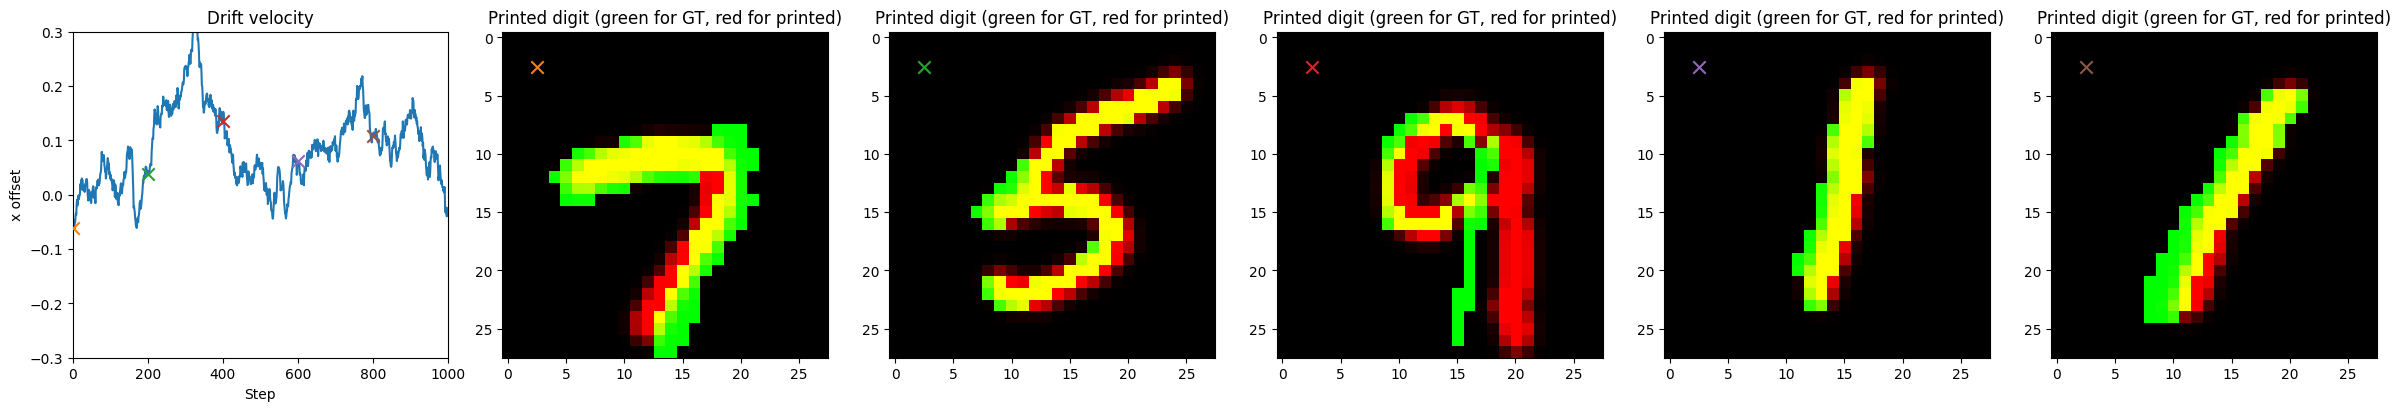

In [ ]:
printer = printer_gene(BW, 0.01)
I0s = np.zeros([0,1,28,28])
Is = np.zeros([0,1,28,28])
pos = np.zeros([0,4])
compensation = np.array([[0,0]])
for i in range(1000):
  output_x, output_y, (I0,I) = next(printer)
  pos = np.vstack([pos, output_x])
  I0s = np.concatenate([I0s, I0.reshape(1,1,28,28)],axis = 0)
  Is = np.concatenate([Is, I.reshape(1,1,28,28)],axis = 0)

f,ax = plt.subplots(1,6,figsize=(24,4), constrained_layout = True)
ax[0].plot(np.arange(pos.shape[0]),pos[:,1], zorder=2)
ax[0].set_title('Drift velocity')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('x offset')
#ax[0].set_aspect(1)
ax[0].set_xlim([0,1000])
ax[0].set_ylim([-0.3,0.3])
for i in range(5):
  ax[0].scatter(i*200, pos[i*200,1],  marker = 'x', color = 'C'+str(i+1), zorder=3,s = 80)
  R = Is[i*200,:,:,:].reshape(28,28,1)
  G = I0s[i*200,:,:,:].reshape(28,28,1)
  RGB = np.concatenate([R,G,G*0],axis = 2)
  ax[i+1].imshow(RGB.reshape(28,28,3))
  ax[i+1].scatter(2.5,2.5,marker = 'x', color = 'C'+str(i+1),s = 80)
  ax[i+1].set_title('Printed digit (green for GT, red for printed)')

Here we use a Contextual Bayesian Optimization (CBO) model to solve the problem. The model has a Siamese CNN based embedding network to learn the latent variables (ideally the drift *x* and *y*, but let's see) from the image pairs. Then a Gaussian Process layer with four input nodes is used to predict a reward score, where two nodes takes the CNN outputs and the other two represent the counter-actions. The hope is: 1. In short times or during the initial stages, despite the output of the CNN does not makes sense, some good condition could still be found by the GP layers through BO process. And any data point generated during this process could be used to train the CNN. 2. Once the CNN is trained, the GP layers do not have to go through a lot of BO steps. Instead, it directly outputs the optimal action.

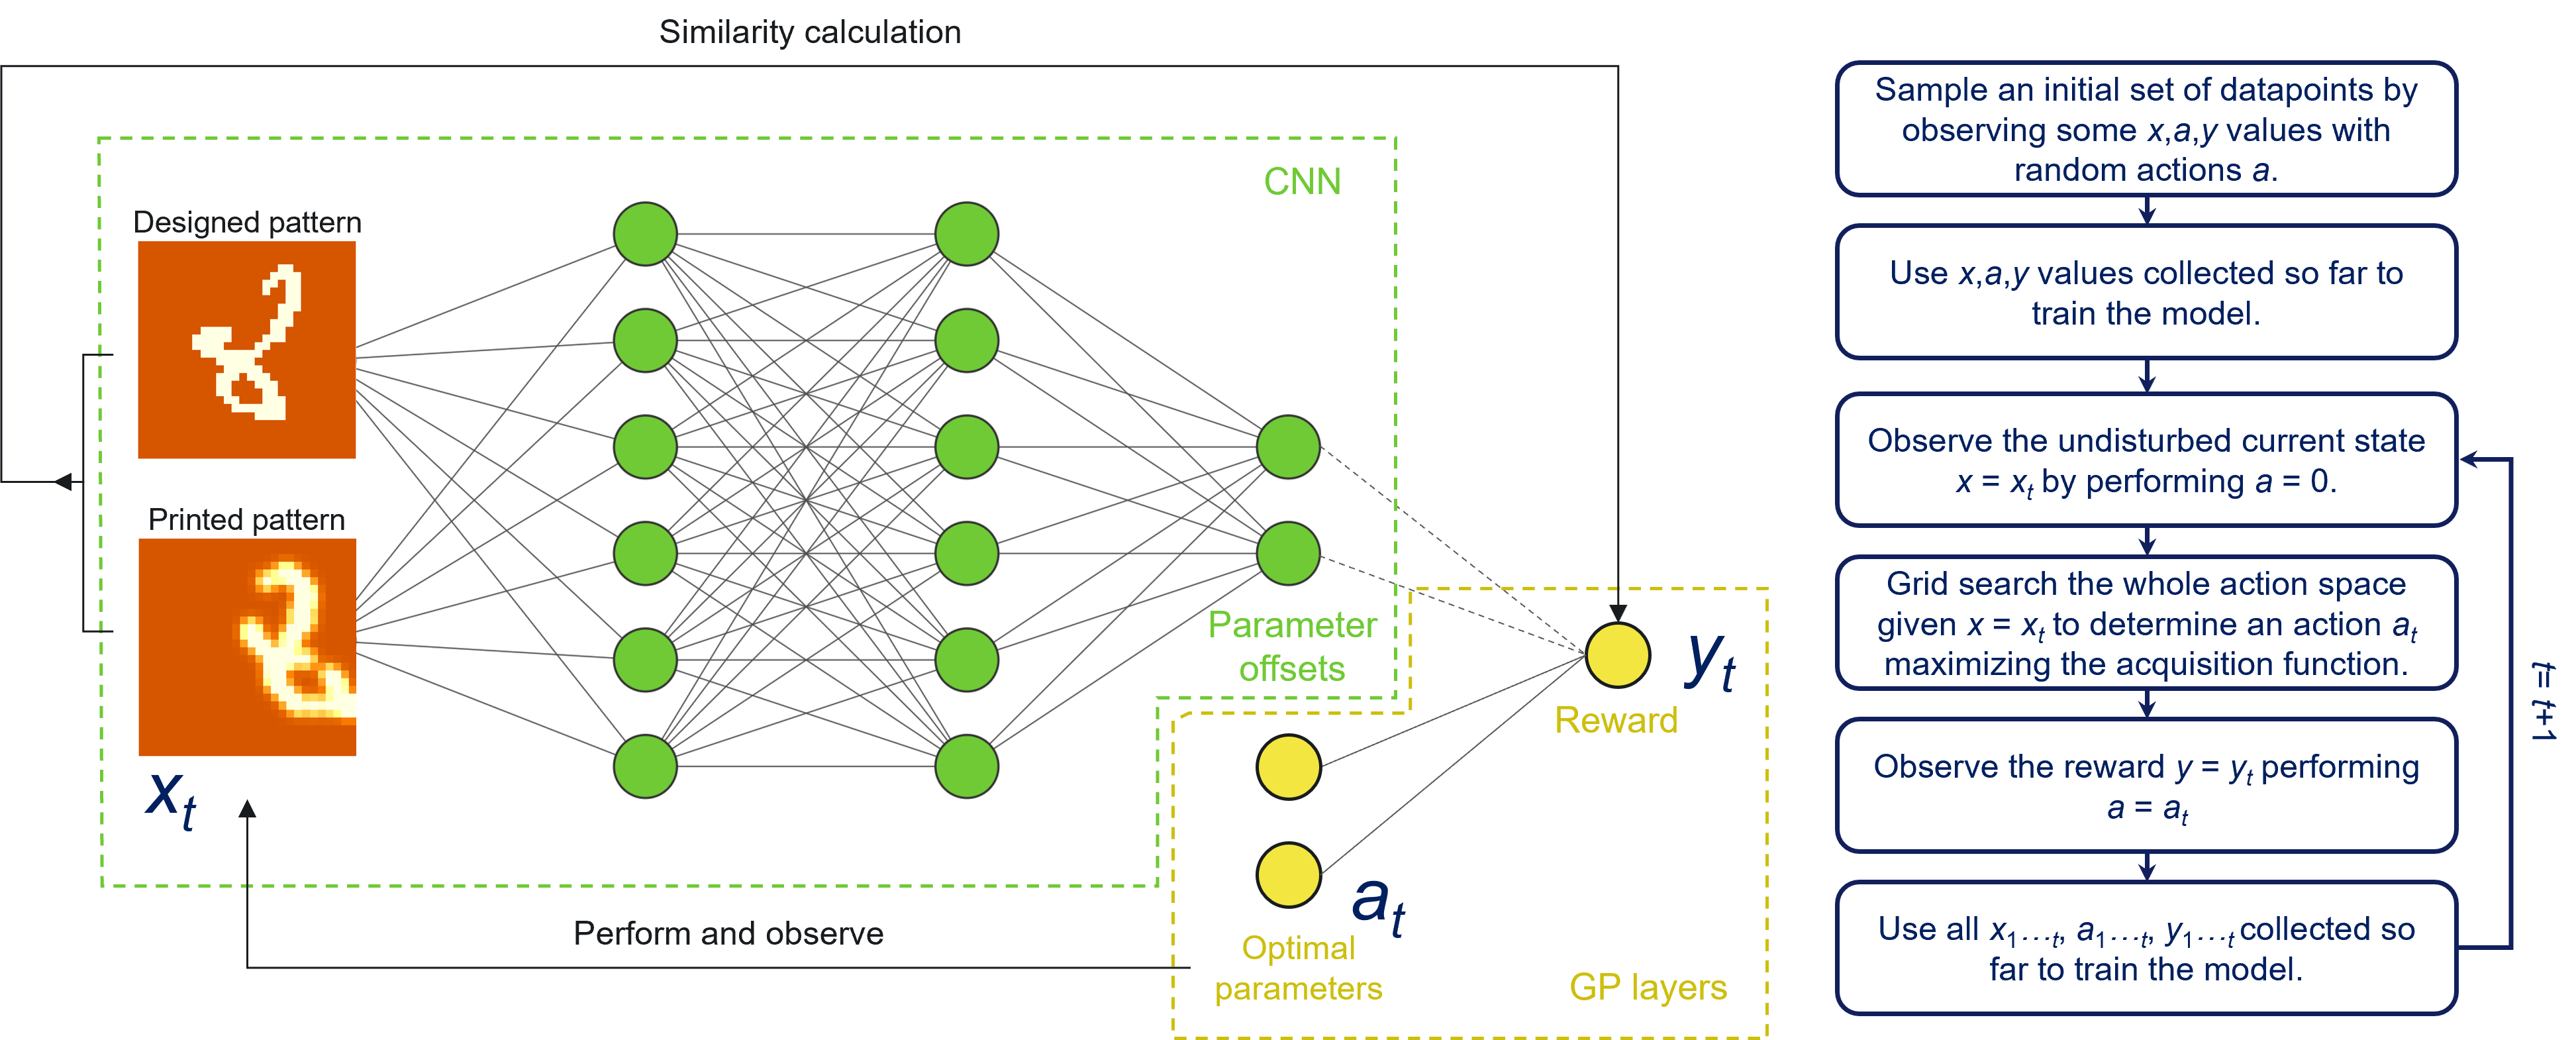

This project is still under development. And the idea above is not fully validated.  
03/14/2025 current stage:  
1. The GP layers could be trained with a pre-trained and untrainable CNN and seem to work.  
2. The randomly intialized Siamese CNN overfits crazily when trained together with the GP layers.
3. Implemented the reward function as the distance to optimal condition at this point. It was supposed to be MSE/SSIM.

03/19/2025 current stage:
1. Achieved the joint training of the Siamese CNN and GP on existing data (no BO): there is still crazy overfitting but not after your have included ~1000 training datapoints. When you don't have enough training data, the CNN overfits by directly learning to map the images to the rewards (mostly ignoring the actions) to get very low loss. Somehow this is doable on a not-big-enough dataset.
2. Implemented the correct reward function as MSE/SSIM. This did not bring any noticeable difference/issues in the training behavior.

Text(0.5, 1.0, 'Reward assignment check')

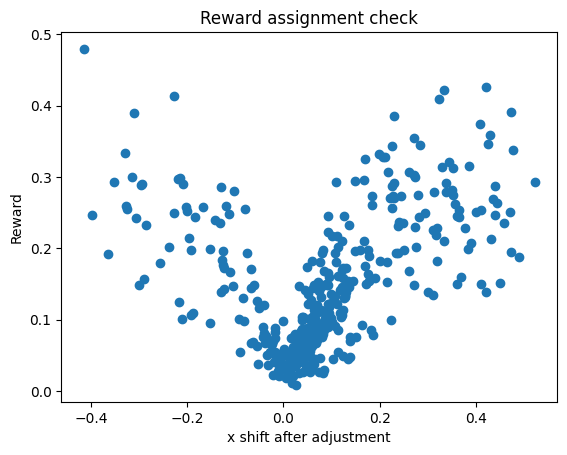

In [ ]:
##Model initialization and intial sampling
##Somehow 1000 samples are needed to achieve the joint learning of CNN and GP, with lr = 0.01, both
printer = printer_gene(BW,0.01)
actions = np.zeros([0,2])
rewards = np.zeros([0])
I0s = np.zeros([0,784])
Is = np.zeros([0,784])
traj = np.zeros([0,1])
##initialization collect x samples
for i in range(200):

    compensation = np.array([[0,0]])
    output_x, output_y, (I0,I) = next(printer)  #Let's first do this in a stupid way. Observe the context first.
    I0s = np.vstack([I0s, I0.reshape(1,784)])
    Is = np.vstack([Is, I.reshape(1,784)])
    actions = np.vstack([actions, compensation])
    traj = np.vstack([traj, output_x[1]])
    rewards = np.concatenate([rewards, np.array([output_y])],axis = 0)

    compensation = (np.random.rand(1,2)-0.5)*0.8   #Determine a random action
    output_x, output_y, (_,_) = next(printer) ##Printer reads the "compensation" globally. Let's throw away the observed images.
    I0s = np.vstack([I0s, I0.reshape(1,784)])
    Is = np.vstack([Is, I.reshape(1,784)])
    actions = np.vstack([actions, compensation])
    traj = np.vstack([traj, output_x[1]])
    rewards = np.concatenate([rewards, np.array([output_y])],axis = 0)

actions = actions[:,1:2]
I0s_torch = torch.from_numpy(I0s).to('cuda').float()
Is_torch = torch.from_numpy(Is).to('cuda').float()
actions_torch = torch.from_numpy(actions).to('cuda').float()
rewards_torch = torch.from_numpy(rewards).to('cuda').float()

#Check the reward (the lower the better) assignment:
#Data points closer to (0,0) should have a lower score.
xx = traj+actions ## traj = randomly offset parameter, action = counter-action, adding them together gives the final location
f,ax = plt.subplots(1)
ax.scatter(xx[:,0], rewards)
ax.set_xlabel('x shift after adjustment')
ax.set_ylabel('Reward')
ax.set_title('Reward assignment check')

In [ ]:
CBO = SiameseCBOModel((I0s_torch, Is_torch, actions_torch), rewards_torch, lr_front = 1e-2, lr_rear=1e-3)
CBO.train_gpmodel((I0s_torch, Is_torch, actions_torch), rewards_torch, num_epochs=2000, verbose = 2,valid = True, train_rear = True)  # Adjust epochs as needed

likelihood.noise_covar.raw_noise torch.Size([1])
Siamese.base_cnn.conv1.weight torch.Size([16, 1, 3, 3])
Siamese.base_cnn.conv1.bias torch.Size([16])
Siamese.base_cnn.conv2.weight torch.Size([16, 16, 3, 3])
Siamese.base_cnn.conv2.bias torch.Size([16])
Siamese.base_cnn.conv3.weight torch.Size([16, 16, 3, 3])
Siamese.base_cnn.conv3.bias torch.Size([16])
Siamese.fc1.weight torch.Size([32, 288])
Siamese.fc1.bias torch.Size([32])
Siamese.fc2.weight torch.Size([1, 32])
Siamese.fc2.bias torch.Size([1])
mean_module.raw_constant torch.Size([])
covar_module.raw_outputscale torch.Size([])
covar_module.base_kernel.raw_lengthscale torch.Size([1, 1])
mean_module.raw_constant torch.Size([])
covar_module.raw_outputscale torch.Size([])
covar_module.base_kernel.raw_lengthscale torch.Size([1, 1])
Epoch 1/2000, Loss: 0.8376, MSE*1000: 4.3531; 0.7881597280502319
Epoch 2/2000, Loss: 0.8305, MSE*1000: 4.3888; 0.7831966280937195
Epoch 3/2000, Loss: 0.8251, MSE*1000: 4.4196; 0.7782578468322754
Epoch 4/2000, Lo

/usr/local/lib/python3.11/dist-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Epoch 7/2000, Loss: 0.8088, MSE*1000: 4.4297; 0.7587444186210632
Epoch 8/2000, Loss: 0.8051, MSE*1000: 4.4387; 0.7539260387420654
Epoch 9/2000, Loss: 0.8015, MSE*1000: 4.4332; 0.7491316199302673
Epoch 10/2000, Loss: 0.7980, MSE*1000: 4.4074; 0.7443609833717346
Epoch 11/2000, Loss: 0.7946, MSE*1000: 4.3624; 0.7396141290664673
Epoch 12/2000, Loss: 0.7911, MSE*1000: 4.3457; 0.7348909378051758
Epoch 13/2000, Loss: 0.7877, MSE*1000: 4.3338; 0.7301914691925049
Epoch 14/2000, Loss: 0.7843, MSE*1000: 4.3000; 0.7255156636238098
Epoch 15/2000, Loss: 0.7809, MSE*1000: 4.2484; 0.720863401889801
Epoch 16/2000, Loss: 0.7776, MSE*1000: 4.1862; 0.7162346839904785
Epoch 17/2000, Loss: 0.7742, MSE*1000: 4.1411; 0.7116295099258423
Epoch 18/2000, Loss: 0.7709, MSE*1000: 4.1322; 0.7070478200912476
Epoch 19/2000, Loss: 0.7676, MSE*1000: 4.1445; 0.7024896144866943
Epoch 20/2000, Loss: 0.7642, MSE*1000: 4.1780; 0.6979548931121826
Epoch 21/2000, Loss: 0.7609, MSE*1000: 4.2056; 0.6934435963630676
Epoch 22/2000,

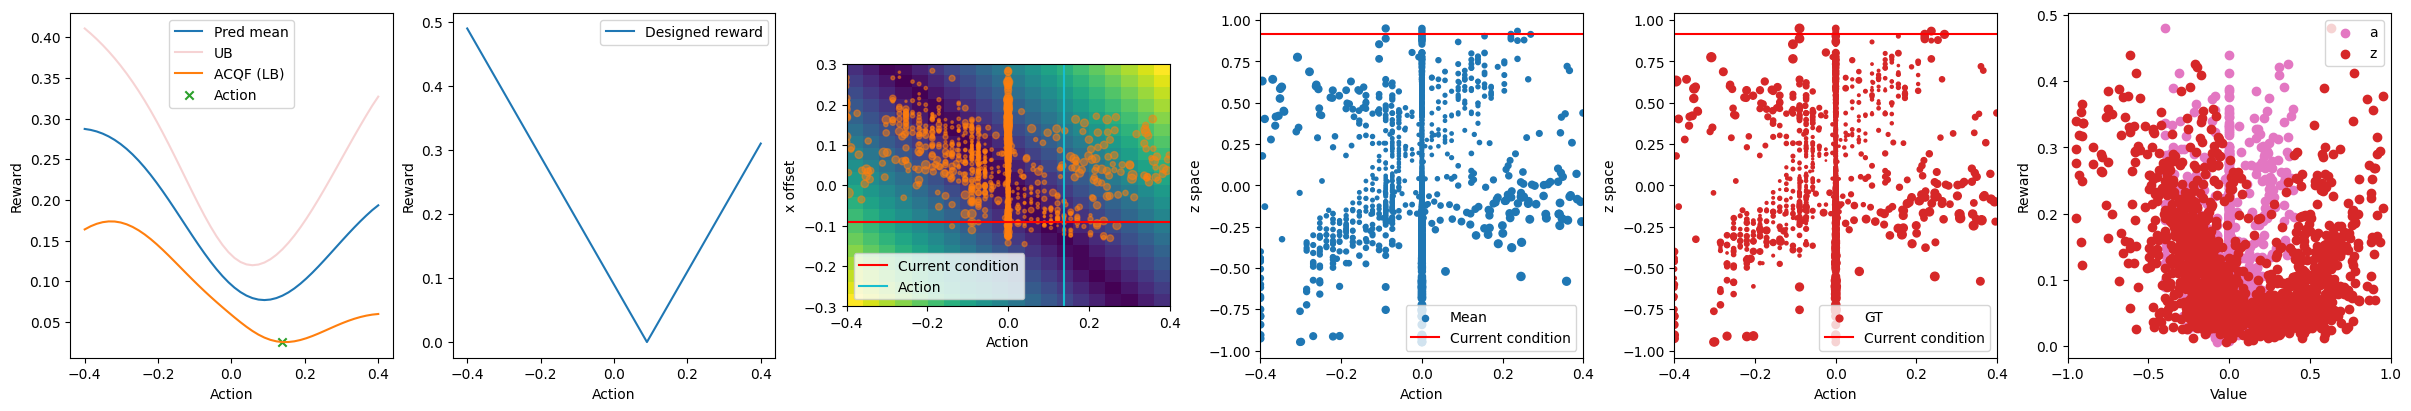

In [ ]:
##Attemps to train the whole thing in the BO fashion
##For figure "Context Trajectory". The orange trajectory is the simulated random instrument offset in random walk. The green trajectory is the corrected parameters by the agent's counter-action. Ideally it stays at (0, 0).
def x_grid_search2():
  x = np.linspace(-0.3,0.3,20)
  a = np.linspace(-0.4,0.4,20)
  xx,aa = np.meshgrid(x,a)
  return np.array([xx.flatten(),aa.flatten()]).T

def test_data_prepare_1D(I0, I):
    a = np.linspace(-0.4,0.4,50)
    x0 = np.repeat(I0, a.shape[0], axis = 0)
    x1 = np.repeat(I, a.shape[0], axis = 0)
    return (x0,x1,a)

from IPython.display import display, clear_output
import time

test_grid = x_grid_search2()
test_GT = np.abs(test_grid[:,1]+test_grid[:,0])
sigma = 0
a_sample = np.linspace(-0.4,0.4,50)
##start the experiment
for i in range(500):
    ## in the stupid version of implementation, we first observe the current context
    compensation = np.array([[0,0]])
    output_x, output_y, (I0,I) = next(printer)  #Let's first do this in a stupid way. Observe the context first.
    I0 = I0.reshape(1,784)
    I = I.reshape(1,784)
    I0s = np.vstack([I0s, I0])
    Is = np.vstack([Is, I])
    traj = np.vstack([traj, output_x[1]])
    actions = np.vstack([actions, compensation[:,1:2]])
    rewards = np.concatenate([rewards, np.array([output_y])],axis = 0)

    ## use the current state/context, give the action with lowest acqf
    x0,x1,x2 = test_data_prepare_1D(I0, I)
    #x0,x1,x2 = test_data_prepare(I0s[-2:-1,:], Is[-2:-1,:])
    x0_torch = torch.from_numpy(x0).to('cuda').float()
    x1_torch = torch.from_numpy(x1).to('cuda').float()
    x2_torch = torch.from_numpy(x2).to('cuda').float()
    GT_display = np.abs(traj[-1,:] + x2)

    mean, lower, upper, debug = CBO.predict((x0_torch,x1_torch, x2_torch))
    acqf = lower + np.random.normal(0,sigma,lower.shape)
    xq = np.argmin(acqf)
    compensation = np.array([[0, a_sample[xq]]])
    actions = np.vstack([actions, compensation[0,1:2]])

    pred = CBO.SiamesePredict((I0s_torch.view(-1,1,28,28), Is_torch.view(-1,1,28,28)))
    pred_reward, _, _, _ = CBO.predict((I0s_torch, Is_torch, actions_torch))
    #######################################

    f,ax = plt.subplots(1,6,figsize=(24,4), constrained_layout = True)
    ax[0].plot(a_sample, mean,color = 'C0', label = 'Pred mean')
    #ax[0].plot(a_sample, lower,color = 'C3', alpha = 0.2, label = 'LB')
    ax[0].plot(a_sample, upper,color = 'C3', alpha = 0.2, label = 'UB')
    ax[0].plot(a_sample, acqf, color = 'C1', label = 'ACQF (LB)')
    ax[0].scatter(a_sample[xq], acqf[xq],color = 'C2', marker = 'x', label = 'Action')
    ax[0].legend()
    ax[0].set_xlabel('Action')
    ax[0].set_ylabel('Reward')

    ax[2].imshow(test_GT.reshape((20,20)).T, extent = (-0.4,0.4,0.3,-0.3))
    ax[2].set_ylabel('x offset')
    ax[2].set_xlabel('Action')
    ax[2].plot(a_sample, a_sample*0+traj[-1,:], label = 'Current condition',color = 'red')
    ax[2].plot(a_sample*0+a_sample[xq], a_sample, label = 'Action',color = 'C9')
    ax[2].set_ylim(-0.3,0.3)
    ax[2].scatter(actions[:-2,:], traj[:-1,:],rewards[:-1]*100, color = 'C1', alpha = 0.5)
    ax[2].legend()
    #ax[2].scatter( traj[-1,1], color = 'red', marker = 'x', s = 80, zorder=4)

    ax[1].plot(a_sample, GT_display,color = 'C0', label = 'Designed reward')
    ax[1].legend()
    ax[1].set_xlabel('Action')
    ax[1].set_ylabel('Reward')

    ax[3].scatter(actions[:-2,0], pred.squeeze(), pred_reward*100, label = 'Mean')
    ax[3].plot(a_sample,a_sample*0+pred.squeeze()[-1], label = 'Current condition',color = 'red')
    ax[3].legend()
    ax[3].set_ylabel('z space')
    ax[3].set_xlabel('Action')
    ax[3].set_xlim(-0.4,0.4)

    ax[4].scatter(actions[:-2,0],pred.squeeze(),  rewards[:-1]*100,color = 'C3', label = 'GT')
    ax[4].plot(a_sample,a_sample*0+pred.squeeze()[-1], label = 'Current condition',color = 'red')
    ax[4].legend()
    ax[4].set_ylabel('z space')
    ax[4].set_xlabel('Action')
    ax[4].set_xlim(-0.4,0.4)

    ax[5].scatter(actions[:-2,0],  rewards[:-1],color = 'C6', label = 'a')
    ax[5].scatter(pred.squeeze(),  rewards[:-1],color = 'C3', label = 'z')
    ax[5].legend()
    ax[5].set_ylabel('Reward')
    ax[5].set_xlabel('Value')
    ax[5].set_xlim(-1,1)

    #######################################
    f.savefig("temp3/"+'{:03d}'.format(i)+".png")

    ##conduct the next roudn of observation and collect the reward
    output_x, output_y, (_,_) = next(printer)

    I0s = np.vstack([I0s, I0])
    Is = np.vstack([Is, I])
    traj = np.vstack([traj, output_x[1]])
    rewards = np.concatenate([rewards, np.array([output_y])],axis = 0)

    I0s_torch = torch.from_numpy(I0s).to('cuda').float()
    Is_torch = torch.from_numpy(Is).to('cuda').float()
    actions_torch = torch.from_numpy(actions).to('cuda').float()
    rewards_torch = torch.from_numpy(rewards).to('cuda').float()

    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)
    #CBO.train_gpmodel((I0s_torch, Is_torch, actions_torch),rewards_torch, num_epochs=20, verbose = 2, valid = 1)
    #if np.mod(i,50) == 0:
    #    CBO.train_gpmodel((I0s_torch, Is_torch, actions_torch), rewards_torch, num_epochs=500, verbose = 0,valid = 0,train_rear = True)

    CBO.train_gpmodel((I0s_torch, Is_torch, actions_torch), rewards_torch, num_epochs=200, verbose = 0,valid = 0,train_rear = True)

Text(0.5, 1.0, 'Reward assignment check')

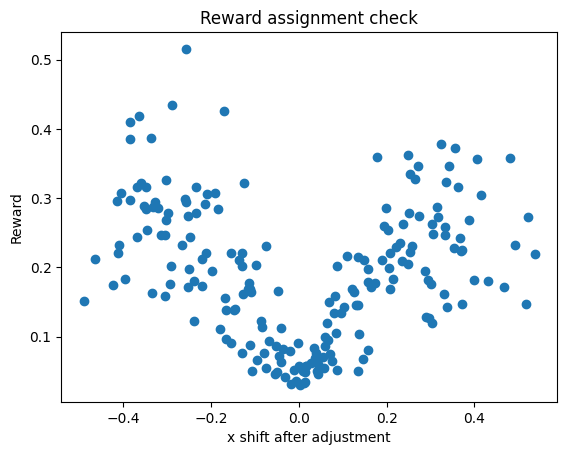

In [ ]:
xx = traj+actions ## traj = randomly offset parameter, action = counter-action, adding them together gives the final location
f,ax = plt.subplots(1)
ax.scatter(xx[:,0], rewards)
ax.set_xlabel('x shift after adjustment')
ax.set_ylabel('Reward')
ax.set_title('Reward assignment check')

Check the rewards in the learned latent space z & action space a: looks good!  
(rotates in the awkward way because I haven't fuound how to interactively adjust the 3d view in matplotlib/colab)

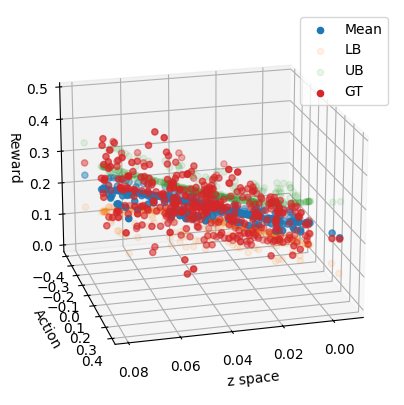

In [ ]:
from IPython.display import display, clear_output

mean, lower, upper, debug = CBO.predict((I0s_torch, Is_torch, actions_torch))
pred = CBO.gpmodel.Siamese(I0s_torch.view(-1,1,28,28), Is_torch.view(-1,1,28,28)).cpu().detach().numpy()

for i in range(20):
  fig = plt.figure(figsize=(5, 5))
  ax = fig.add_subplot(projection='3d')
  ax.scatter(pred.squeeze(), actions[:,0], mean, label = 'Mean')
  ax.scatter(pred.squeeze(), actions[:,0], lower, label = 'LB', alpha = 0.1)
  ax.scatter(pred.squeeze(), actions[:,0], upper, label = 'UB', alpha = 0.1)
  ax.scatter(pred.squeeze(), actions[:,0], rewards,color = 'C3', label = 'GT')
  ax.view_init(elev=20, azim=-20+5*i)
  ax.legend()
  ax.set_xlabel('z space')
  ax.set_ylabel('Action')
  ax.set_zlabel('Reward')
  plt.show()
  #break
  time.sleep(0.01)
  clear_output(wait=True)


Very simply, the ideal counter-action (or lower(better) reward counter-action\) is supposed to be the negative current x shift or offset to keep the final result zero. Figures below show that policy could be learned.

Text(400.9040404040403, 0.5, 'Action')

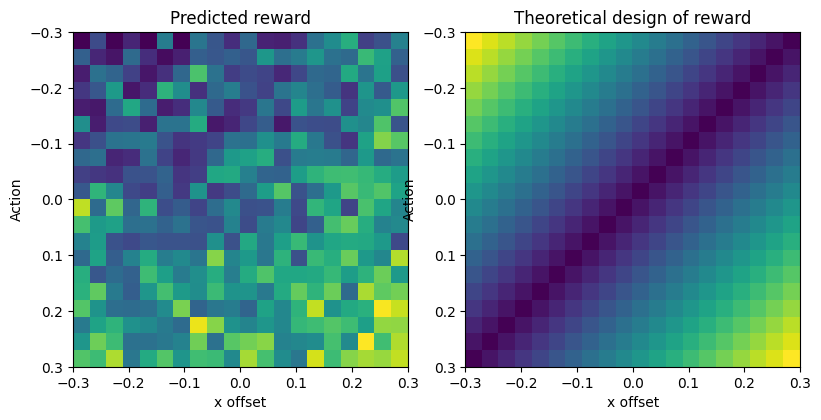

In [ ]:
def x_grid_search2():
  x = np.linspace(-0.3,0.3,20)
  a = np.linspace(-0.3,0.3,20)
  xx,aa = np.meshgrid(x,a)
  return np.array([xx.flatten(),aa.flatten()]).T

test_grid = x_grid_search2()

I0s_test = np.zeros([0,784])
Is_test = np.zeros([0,784])

for i in range(test_grid.shape[0]):
    output_x, _, (I0,I) = printer_gene_test(BW, test_grid[i,0])
    I0s_test = np.vstack([I0s_test, I0.reshape(1,784)])
    Is_test = np.vstack([Is_test, I.reshape(1,784)])

x0_test_torch = torch.from_numpy(I0s_test).to('cuda').float()
x1_test_torch = torch.from_numpy(Is_test).to('cuda').float()
x2_test_torch = torch.from_numpy(test_grid[:,1:2]).to('cuda').float()

mean, lower, upper, debug = CBO.predict((x0_test_torch, x1_test_torch, x2_test_torch))
pred = CBO.gpmodel.Siamese(x0_test_torch.view(-1,1,28,28), x1_test_torch.view(-1,1,28,28)).cpu().detach().numpy()
test_GT = np.abs(test_grid[:,1]+test_grid[:,0])

f,ax = plt.subplots(1,2,figsize=(8, 4))
f.tight_layout()
ax[0].imshow(mean.reshape((20,20)), extent = (-0.3,0.3,0.3,-0.3))
ax[1].imshow(test_GT.reshape((20,20)), extent = (-0.3,0.3,0.3,-0.3))
ax[0].set_title('Predicted reward')
ax[1].set_title('Theoretical design of reward')
ax[0].set_xlabel('x offset')
ax[0].set_ylabel('Action')
ax[1].set_xlabel('x offset')
ax[1].set_ylabel('Action')

Check the rewards in the learned latent space z & action space a: looks good!  
This one is on test data. Test data covers the full range of possible x offests.

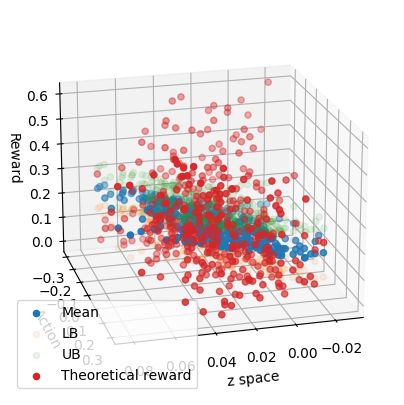

In [ ]:

test_GT = np.abs(test_grid[:,1]+test_grid[:,0])
for i in range(20):
  fig = plt.figure(figsize=(5, 5))
  ax = fig.add_subplot(projection='3d')
  ax.scatter(pred.squeeze(), test_grid[:,1], mean, label = 'Mean')
  ax.scatter(pred.squeeze(), test_grid[:,1], lower, label = 'LB', alpha = 0.1)
  ax.scatter(pred.squeeze(), test_grid[:,1], upper, label = 'UB', alpha = 0.1)
  ax.scatter(pred.squeeze(), test_grid[:,1], test_GT, color = 'C3', label = 'Theoretical reward')
  ax.view_init(elev=20, azim=-20+5*i)
  ax.legend()
  ax.set_xlabel('z space')
  ax.set_ylabel('Action')
  ax.set_zlabel('Reward')
  plt.show()
  time.sleep(0.01)
  clear_output(wait=True)

Check the reward predictions on training datasets. Somehow there is a cut-off on y-axis but this is not a serious problem and it sometimes goes away with more training epochs.

(-0.01, 0.3)

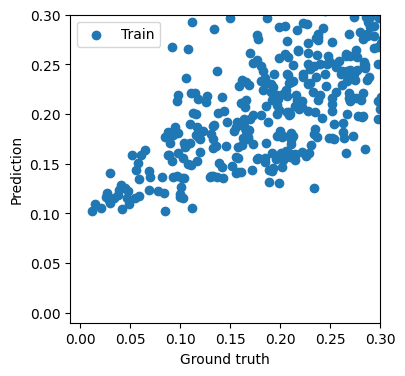

In [ ]:
f,ax = plt.subplots(1,figsize=(4, 4))

mean, lower, upper, debug = CBO.predict((I0s_torch, Is_torch, actions_torch))
ax.scatter(rewards,mean, label='Train')

mean, lower, upper, debug = CBO.predict((x0_test_torch, x1_test_torch, x2_test_torch))
#ax.scatter(test_GT,mean, label='Test')
ax.set_xlabel('Ground truth')
ax.set_ylabel('Prediction')
ax.legend()
ax.set_xlim(-0.01,0.3)
ax.set_ylim(-0.01,0.3)

Check if the learned latent space match with the x input space (did the CNN learn to predict the drift?), since this is reward driven, and there is no guarantee on that.  

It looks good even on the test data. Note the exact magnitude and sign (positive or negative slopes in the figure below) of the z latent space are not important.

It even does some extrapolation!

Text(0, 0.5, 'z space')

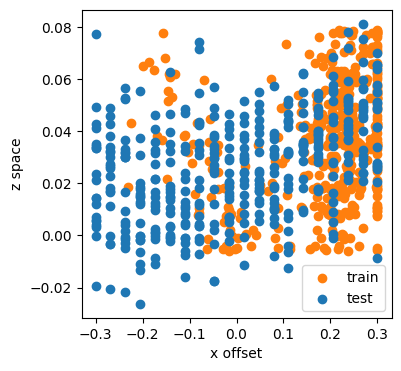

In [ ]:
f,ax = plt.subplots(1,figsize=(4, 4))

pred = CBO.gpmodel.Siamese(I0s_torch.view(-1,1,28,28), Is_torch.view(-1,1,28,28)).cpu() .detach().numpy()
ax.scatter(traj[:,0], pred[:,0], label='train',color = 'C1')

pred = CBO.gpmodel.Siamese(x0_test_torch.view(-1,1,28,28), x1_test_torch.view(-1,1,28,28)).cpu() .detach().numpy()
ax.scatter(test_grid[:,0], pred[:,0], label='test',color = 'C0')

ax.legend()
ax.set_xlabel('x offset')
ax.set_ylabel('z space')